In [1]:
# se importan librerias
import pandas as pd                    # dataframe
from dibuja import *                   # para plots
from regEX import *                    # expresiones regulares, clasificacion ataque
from shark import *                    # expresiones regulares, limpieza especie

In [2]:
'''
Mi objetivo es relacionar la mortalidad y el tipo de daños causados con la 
especie de tiburon para descubrir, no solo que especie es la que genera mayor tasa de mortalidad, 
sino tambien que especie provoca mayores daños no mortales.

En una segunda parte intentare construir una serie temporal con esa informacion 
para tratar de responder una pregunta:
¿los tiburones se estan volviendo mas agresivos con el tiempo?.  
'''


'\nMi objetivo es relacionar la mortalidad y el tipo de daños causados con la \nespecie de tiburon para descubrir, no solo que especie es la que genera mayor tasa de mortalidad, \nsino tambien que especie provoca mayores daños no mortales.\n\nEn una segunda parte intentare construir una serie temporal con esa informacion \npara tratar de responder una pregunta:\n¿los tiburones se estan volviendo mas agresivos con el tiempo?.  \n'

In [3]:
datos=pd.read_csv('attacks.csv', encoding='ISO-8859-1')           # se crea el dataframe
#display (datos)
#display (datos.columns)
display (datos.head())

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN


In [4]:
datos=datos[['Year', 'Type', 'Activity', 'Species ', 'Injury', 'Fatal (Y/N)']]  # se escogen los datos a tratar
# elimino el resto de columnas porque no me hacen falta para el proposito del estudio

datos=datos.rename(columns={'Year': 'Año', 'Type': 'Tipo', 'Activity': 'Actividad',\
                            'Species ': 'Especie', 'Injury': 'Daños', 'Fatal (Y/N)': 'Mortal'}) 
# renombro las columnas por comodidad

display (datos.head())

,Año,Tipo,Actividad,Especie,Daños,Mortal
0,2018.0,Boating,Paddling,White shark,"No injury to occupant, outrigger canoe and pad...",N
1,2018.0,Unprovoked,Standing,NaN,Minor injury to left thigh,N
2,2018.0,Invalid,Surfing,NaN,Injury to left lower leg from surfboard skeg,N
3,2018.0,Unprovoked,Surfing,2 m shark,Minor injury to lower leg,N
4,2018.0,Provoked,Free diving,"Tiger shark, 3m",Lacerations to leg & hand shark PROVOKED INCIDENT,N


In [5]:
datos=datos.dropna(how='all')                        # elimina Nan, desde el registro 6302 no hay datos
#print (datos.shape)
datos=datos[datos.Año>=1940]                         # una primera seleccion de datos, desde 1940
print (datos.shape)                                  # 4780 registros
#print (datos['Año'])

(4780, 6)


In [6]:
datos=datos.fillna('UNKNOWN')                                   # renombro los valores nulos...
datos=datos[datos['Especie'].map(lambda x: str(x)!='UNKNOWN')]  # ... y los elimino segun ese nombre.
datos=datos.drop_duplicates()                                   # se eliminan duplicados
datos.index=range(len(datos))                                   # reindexo el frame por si lo necesito en el futuro 
print (datos.shape)                                             # 2980 registros
null=datos.isna().sum()                                         # se miran los valores nulos
print (null[null>0])                                            # el frame esta limpio

(2980, 6)
Series([], dtype: int64)


In [7]:
# clasifico el tipo de ataque: clase '0'=sin daños, '1'=daño bajo, '2'=daño medio, '3'=daño alto, '4'=mortal
datos.loc[datos['Mortal']=='Y', 'Daños']='4'                     # cambio los mortales a clase '4'
strings=[datos['Daños'][i].lower() for i in range(len(datos))]   # pasa a minusculas
datos['Clase_Daños']=regEX(strings)                              # clasificacion categorica de los ataques
display (datos.head())

,Año,Tipo,Actividad,Especie,Daños,Mortal,Clase_Daños
0,2018.0,Boating,Paddling,White shark,"No injury to occupant, outrigger canoe and pad...",N,0
1,2018.0,Unprovoked,Surfing,2 m shark,Minor injury to lower leg,N,1
2,2018.0,Provoked,Free diving,"Tiger shark, 3m",Lacerations to leg & hand shark PROVOKED INCIDENT,N,2
3,2018.0,Unprovoked,Swimming,Tiger shark,4,Y,4
4,2018.0,Unprovoked,Fishing,"Lemon shark, 3'",Minor injury to foot. PROVOKED INCIDENT,N,1


In [8]:
# Ahora las especies
str_shark=[datos['Especie'][i].lower() for i in range(len(datos))]   # pasa a minusculas
datos['Especie(clean)']=shark(str_shark)                             # limpieza especies
display (datos.head())

,Año,Tipo,Actividad,Especie,Daños,Mortal,Clase_Daños,Especie(clean)
0,2018.0,Boating,Paddling,White shark,"No injury to occupant, outrigger canoe and pad...",N,0,White
1,2018.0,Unprovoked,Surfing,2 m shark,Minor injury to lower leg,N,1,Other
2,2018.0,Provoked,Free diving,"Tiger shark, 3m",Lacerations to leg & hand shark PROVOKED INCIDENT,N,2,Tiger
3,2018.0,Unprovoked,Swimming,Tiger shark,4,Y,4,Tiger
4,2018.0,Unprovoked,Fishing,"Lemon shark, 3'",Minor injury to foot. PROVOKED INCIDENT,N,1,Lemon


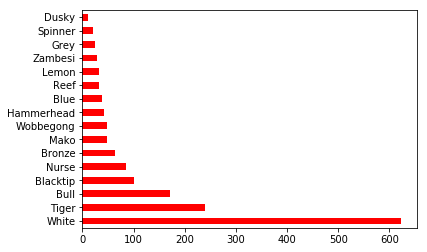

In [9]:
# plot por especie, numero de ataques
tiburones=datos['Especie(clean)'].value_counts()
tiburones[(tiburones<800) & (tiburones>10)].plot.barh(color='red')
plt.show()

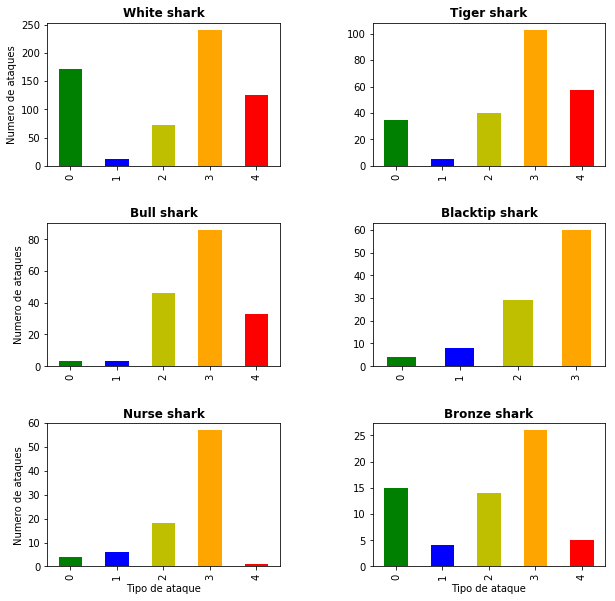

Tipo de ataque: '0'=sin daños, '1'=daño bajo, '2'=daño medio, '3'=daño alto, '4'=mortal	        	         	        Dibujo de las 6 especies de tiburón que más atacan.


In [10]:
# plots tipo de ataque y especie (blanco, tigre, toro, punta negra, nodriza, bronce)
plt.rcParams["figure.figsize"] =(10,10)         # ajuste de tamaño completo
print(dibuja(datos))                            # subplots de 6 especies
